# Store-Level Power Analysis for Menu Board Changes

This notebook simulates power analysis for a store-level experiment with the following parameters:
- Total stores: 3,000
- Treatment: Changes to display panel in digital menu board
- Primary KPI: Average Order Value (AOV) - currently $10 nationally
- Goal: Determine minimum detectable effect (MDE) for different combinations of:
  - Treatment store count (varying)
  - Test duration (2 weeks, 4 weeks, 8 weeks)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from tqdm.notebook import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## 1. Define Parameters

First, let's define the parameters for our simulation:

In [8]:
# Experiment parameters
TOTAL_STORES = 3000
BASELINE_AOV = 10.0  # Current average order value in dollars

# AOV statistics (based on typical restaurant operations)
# Standard deviation represents variation in AOV between stores
STORE_AOV_STD = 2.0  # Assuming $2 standard deviation between stores

# Day-to-day standard deviation within a store (assuming 15% daily fluctuation)
DAILY_CV = 0.15  # Coefficient of variation for daily AOV
DAILY_AOV_STD = BASELINE_AOV * DAILY_CV

# Test scenarios - reduced for demo
TREATMENT_STORE_COUNTS = [100, 300, 500]  # Reduced from [50, 100, 200, 300, 500, 750, 1000]
TEST_DURATIONS_WEEKS = [2, 4]  # Reduced from [2, 4, 8]
TEST_DURATIONS_DAYS = [weeks * 7 for weeks in TEST_DURATIONS_WEEKS]

# Effects to test - reduced for demo
EFFECT_SIZES_PERCENT = [1.0, 3.0]  # Reduced from [0.5, 1.0, 1.5, 2.0, 3.0, 5.0]
EFFECT_SIZES = [BASELINE_AOV * effect_size / 100 for effect_size in EFFECT_SIZES_PERCENT]

# Statistical parameters
ALPHA = 0.05  # Type I error rate (significance level)
TARGET_POWER = 0.8  # 1 - Type II error rate (power)
N_SIMULATIONS = 30  # Reduced from 500 to make it faster

## 2. Create Store Data

Now let's create a dataset of stores with baseline AOV values:

In [3]:
def create_store_data():
    """
    Create a dataframe with store-level data including baseline AOV
    """
    store_ids = np.arange(1, TOTAL_STORES + 1)
    
    # Generate store-level baseline AOV with some natural variation
    # Using truncated normal to avoid negative values
    store_aov = stats.truncnorm(
        (5 - BASELINE_AOV) / STORE_AOV_STD,  # Lower bound at $5
        (20 - BASELINE_AOV) / STORE_AOV_STD,  # Upper bound at $20
        loc=BASELINE_AOV,
        scale=STORE_AOV_STD
    ).rvs(TOTAL_STORES)
    
    # Create dataframe
    stores_df = pd.DataFrame({
        'store_id': store_ids,
        'baseline_aov': store_aov
    })
    
    return stores_df

# Create the store data
stores_df = create_store_data()

# Display the first few rows and summary statistics
print(f"Total stores: {len(stores_df)}")
print(f"Average baseline AOV: ${stores_df['baseline_aov'].mean():.2f}")
stores_df.head()

Total stores: 3000
Average baseline AOV: $10.03


,store_id,baseline_aov
0,1,9.380754
1,2,13.309652
2,3,11.247828
3,4,10.512652
4,5,8.021410


Let's visualize the distribution of baseline AOV across stores:

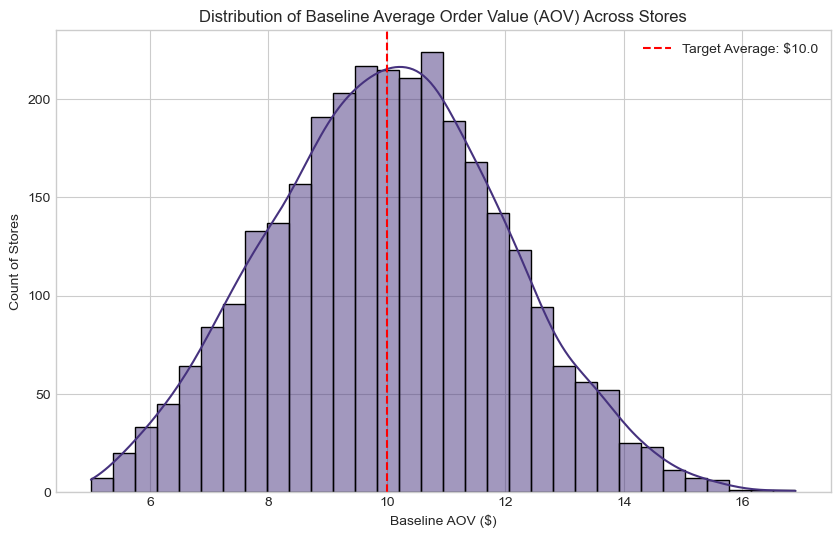

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(stores_df['baseline_aov'], kde=True)
plt.axvline(BASELINE_AOV, color='r', linestyle='--', label=f'Target Average: ${BASELINE_AOV}')
plt.title('Distribution of Baseline Average Order Value (AOV) Across Stores')
plt.xlabel('Baseline AOV ($)')
plt.ylabel('Count of Stores')
plt.legend()
plt.show()

## 3. Theoretical Power Analysis

Before running simulations, let's calculate the theoretical minimum detectable effect (MDE) for different treatment sample sizes and test durations:

In [9]:
def calculate_theoretical_mde(n_treatment, test_duration_days):
    """
    Calculate theoretical minimum detectable effect based on sample size
    
    Parameters:
    - n_treatment: Number of stores in treatment group
    - test_duration_days: Number of days in test period
    
    Returns:
    - mde: Minimum detectable effect in dollars
    - mde_percent: Minimum detectable effect as percentage of baseline
    """
    # Equal sample sizes in treatment and control
    n_control = n_treatment
    
    # Calculate effective standard error
    # As test duration increases, day-to-day variance decreases by sqrt(n)
    effective_daily_std = DAILY_AOV_STD / np.sqrt(test_duration_days)
    
    # Combined standard deviation (store-level + daily variation)
    combined_std = np.sqrt(STORE_AOV_STD**2 + effective_daily_std**2)
    
    # Calculate effect size based on power analysis
    power_analysis = TTestIndPower()
    effect_size = power_analysis.solve_power(
        nobs1=n_treatment,
        ratio=n_control/n_treatment,
        alpha=ALPHA,
        power=TARGET_POWER,
        alternative='two-sided'
    )
    
    # Convert effect size to dollar amount
    # Cohen's d = mean difference / pooled std
    mde = effect_size * combined_std
    mde_percent = (mde / BASELINE_AOV) * 100
    
    return mde, mde_percent

# Calculate theoretical MDE for all combinations
theoretical_results = []

for n_treatment in TREATMENT_STORE_COUNTS:
    for duration_days in TEST_DURATIONS_DAYS:
        duration_weeks = duration_days // 7
        mde, mde_percent = calculate_theoretical_mde(n_treatment, duration_days)
        theoretical_results.append({
            'treatment_stores': n_treatment,
            'test_duration_weeks': duration_weeks,
            'test_duration_days': duration_days,
            'mde_dollars': mde,
            'mde_percent': mde_percent
        })

# Convert to DataFrame and display
theoretical_df = pd.DataFrame(theoretical_results)
theoretical_df = theoretical_df.sort_values(['test_duration_weeks', 'treatment_stores'])
theoretical_df

,treatment_stores,test_duration_weeks,test_duration_days,mde_dollars,mde_percent
0,100,2,14,0.812117,8.121174
2,300,2,14,0.467348,4.673477
4,500,2,14,0.361773,3.617725
1,100,4,28,0.804237,8.042368
3,300,4,28,0.462813,4.628126
5,500,4,28,0.358262,3.582620


Let's visualize the theoretical minimum detectable effect for different scenarios:

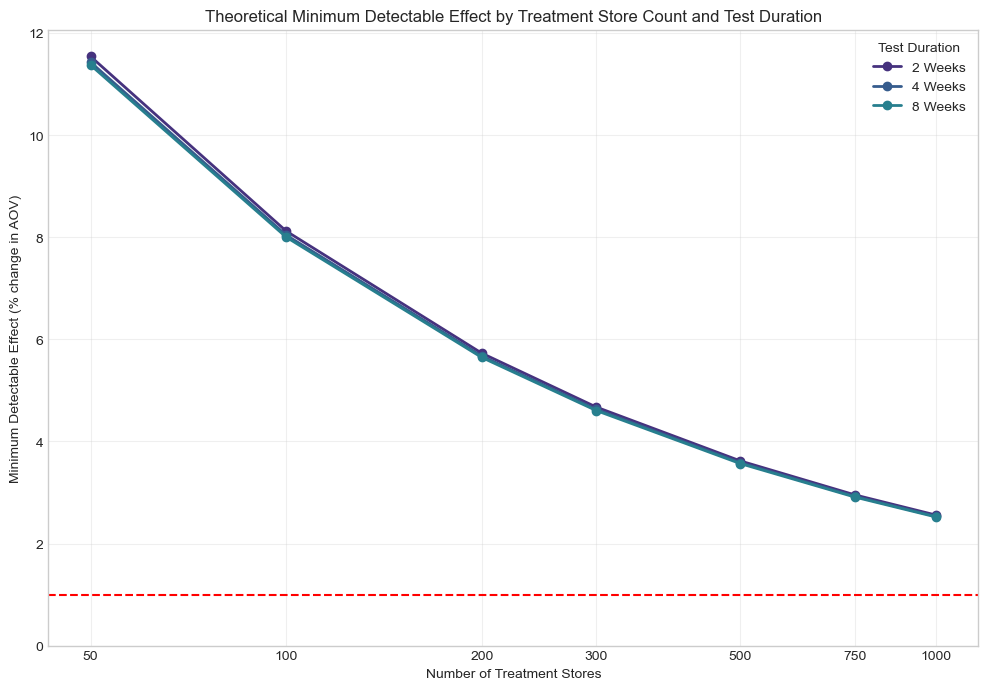

In [6]:
plt.figure(figsize=(12, 8))

for duration in TEST_DURATIONS_WEEKS:
    subset = theoretical_df[theoretical_df['test_duration_weeks'] == duration]
    plt.plot(subset['treatment_stores'], subset['mde_percent'], 
             marker='o', linewidth=2, label=f'{duration} Weeks')

plt.title('Theoretical Minimum Detectable Effect by Treatment Store Count and Test Duration')
plt.xlabel('Number of Treatment Stores')
plt.ylabel('Minimum Detectable Effect (% change in AOV)')
plt.grid(True, alpha=0.3)
plt.legend(title='Test Duration')
plt.xscale('log')
plt.xticks(TREATMENT_STORE_COUNTS, [str(x) for x in TREATMENT_STORE_COUNTS])
plt.axhline(y=1.0, color='r', linestyle='--', label='1% Threshold')
plt.ylim(bottom=0)
plt.show()

## 4. Simulation-Based Power Analysis

Now let's run simulations to estimate the power for different effect sizes, treatment store counts, and test durations:

In [7]:
def generate_daily_data(stores_df, treatment_stores, effect_size, test_duration_days):
    """
    Generate daily AOV data for treatment and control stores over the test period
    
    Parameters:
    - stores_df: DataFrame with store information
    - treatment_stores: List of store IDs in treatment group
    - effect_size: Effect size in dollars to apply to treatment group
    - test_duration_days: Number of days in test period
    
    Returns:
    - daily_df: DataFrame with daily AOV data for all stores
    """
    # Create a copy of the stores dataframe
    sim_stores = stores_df.copy()
    
    # Mark treatment stores
    sim_stores['is_treatment'] = sim_stores['store_id'].isin(treatment_stores)
    
    # Calculate expected AOV for each store
    sim_stores['expected_aov'] = sim_stores['baseline_aov']
    sim_stores.loc[sim_stores['is_treatment'], 'expected_aov'] += effect_size
    
    # Generate daily data
    daily_data = []
    
    for day in range(1, test_duration_days + 1):
        for _, store in sim_stores.iterrows():
            # Generate daily AOV with noise
            daily_aov = np.random.normal(store['expected_aov'], DAILY_AOV_STD)
            
            # Ensure AOV is not negative
            daily_aov = max(daily_aov, 0.01)
            
            daily_data.append({
                'day': day,
                'store_id': store['store_id'],
                'is_treatment': store['is_treatment'],
                'aov': daily_aov
            })
    
    return pd.DataFrame(daily_data)

def run_experiment(stores_df, n_treatment, effect_size, test_duration_days):
    """
    Run a single experiment simulation
    
    Parameters:
    - stores_df: DataFrame with store information
    - n_treatment: Number of stores in treatment group
    - effect_size: Effect size in dollars to apply to treatment group
    - test_duration_days: Number of days in test period
    
    Returns:
    - p_value: p-value from the statistical test
    - estimated_effect: Estimated effect size from the experiment
    """
    # Randomly select treatment stores
    treatment_stores = np.random.choice(stores_df['store_id'], size=n_treatment, replace=False)
    
    # Generate daily data
    daily_df = generate_daily_data(stores_df, treatment_stores, effect_size, test_duration_days)
    
    # Aggregate data by store to get average AOV over the test period
    store_results = daily_df.groupby(['store_id', 'is_treatment'])['aov'].mean().reset_index()
    
    # Separate treatment and control groups
    treatment_aov = store_results[store_results['is_treatment']]['aov']
    control_aov = store_results[~store_results['is_treatment']]['aov']
    
    # Perform statistical test (t-test)
    t_stat, p_value = stats.ttest_ind(treatment_aov, control_aov, equal_var=False)
    
    # Calculate estimated effect size
    estimated_effect = treatment_aov.mean() - control_aov.mean()
    
    return p_value, estimated_effect

def calculate_power(stores_df, n_treatment, effect_size, test_duration_days, n_simulations=N_SIMULATIONS):
    """
    Calculate power through simulation
    
    Parameters:
    - stores_df: DataFrame with store information
    - n_treatment: Number of stores in treatment group
    - effect_size: Effect size in dollars to apply to treatment group
    - test_duration_days: Number of days in test period
    - n_simulations: Number of simulations to run
    
    Returns:
    - power: Proportion of simulations where null hypothesis was correctly rejected
    - mean_estimated_effect: Mean estimated effect across simulations
    """
    # Run multiple simulations
    significant_count = 0
    estimated_effects = []
    
    for _ in range(n_simulations):
        p_value, estimated_effect = run_experiment(stores_df, n_treatment, effect_size, test_duration_days)
        
        # Check if result is statistically significant
        if p_value < ALPHA:
            significant_count += 1
            
        estimated_effects.append(estimated_effect)
    
    # Calculate power and mean estimated effect
    power = significant_count / n_simulations
    mean_estimated_effect = np.mean(estimated_effects)
    
    return power, mean_estimated_effect

Now let's run the simulations for our scenarios. This may take some time to complete:

In [10]:
# Run simulations for different scenarios
simulation_results = []

# Progress tracking
total_scenarios = len(TREATMENT_STORE_COUNTS) * len(TEST_DURATIONS_DAYS) * len(EFFECT_SIZES)
scenario_count = 0

for n_treatment in TREATMENT_STORE_COUNTS:
    for duration_days in TEST_DURATIONS_DAYS:
        duration_weeks = duration_days // 7
        for effect_size in EFFECT_SIZES:
            effect_percent = (effect_size / BASELINE_AOV) * 100
            
            # Run simulation
            power, mean_effect = calculate_power(
                stores_df, 
                n_treatment, 
                effect_size, 
                duration_days, 
                n_simulations=N_SIMULATIONS
            )
            
            # Store results
            simulation_results.append({
                'treatment_stores': n_treatment,
                'test_duration_weeks': duration_weeks,
                'test_duration_days': duration_days,
                'effect_size_dollars': effect_size,
                'effect_size_percent': effect_percent,
                'power': power,
                'mean_estimated_effect': mean_effect
            })
            
            # Update progress
            scenario_count += 1
            print(f"Completed scenario {scenario_count}/{total_scenarios}: "
                  f"{n_treatment} stores, {duration_weeks} weeks, {effect_percent:.1f}% effect - "
                  f"Power: {power:.2f}")

# Convert to DataFrame
simulation_df = pd.DataFrame(simulation_results)
simulation_df = simulation_df.sort_values(['test_duration_weeks', 'treatment_stores', 'effect_size_percent'])
simulation_df

Completed scenario 1/12: 100 stores, 2 weeks, 1.0% effect - Power: 0.10
Completed scenario 2/12: 100 stores, 2 weeks, 3.0% effect - Power: 0.30
Completed scenario 2/12: 100 stores, 2 weeks, 3.0% effect - Power: 0.30
Completed scenario 3/12: 100 stores, 4 weeks, 1.0% effect - Power: 0.17
Completed scenario 3/12: 100 stores, 4 weeks, 1.0% effect - Power: 0.17
Completed scenario 4/12: 100 stores, 4 weeks, 3.0% effect - Power: 0.40
Completed scenario 4/12: 100 stores, 4 weeks, 3.0% effect - Power: 0.40
Completed scenario 5/12: 300 stores, 2 weeks, 1.0% effect - Power: 0.00
Completed scenario 5/12: 300 stores, 2 weeks, 1.0% effect - Power: 0.00
Completed scenario 6/12: 300 stores, 2 weeks, 3.0% effect - Power: 0.80
Completed scenario 6/12: 300 stores, 2 weeks, 3.0% effect - Power: 0.80
Completed scenario 7/12: 300 stores, 4 weeks, 1.0% effect - Power: 0.17
Completed scenario 7/12: 300 stores, 4 weeks, 1.0% effect - Power: 0.17
Completed scenario 8/12: 300 stores, 4 weeks, 3.0% effect - Powe

,treatment_stores,test_duration_weeks,test_duration_days,effect_size_dollars,effect_size_percent,power,mean_estimated_effect
0,100,2,14,0.1,1.0,0.100000,0.100286
1,100,2,14,0.3,3.0,0.300000,0.303647
4,300,2,14,0.1,1.0,0.000000,0.083259
5,300,2,14,0.3,3.0,0.800000,0.286101
8,500,2,14,0.1,1.0,0.233333,0.129855
9,500,2,14,0.3,3.0,0.866667,0.295643
2,100,4,28,0.1,1.0,0.166667,0.123631
3,100,4,28,0.3,3.0,0.400000,0.351079
6,300,4,28,0.1,1.0,0.166667,0.122674
7,300,4,28,0.3,3.0,0.600000,0.280723


## 5. Visualize Simulation Results

Let's create visualizations to help understand the power analysis results:

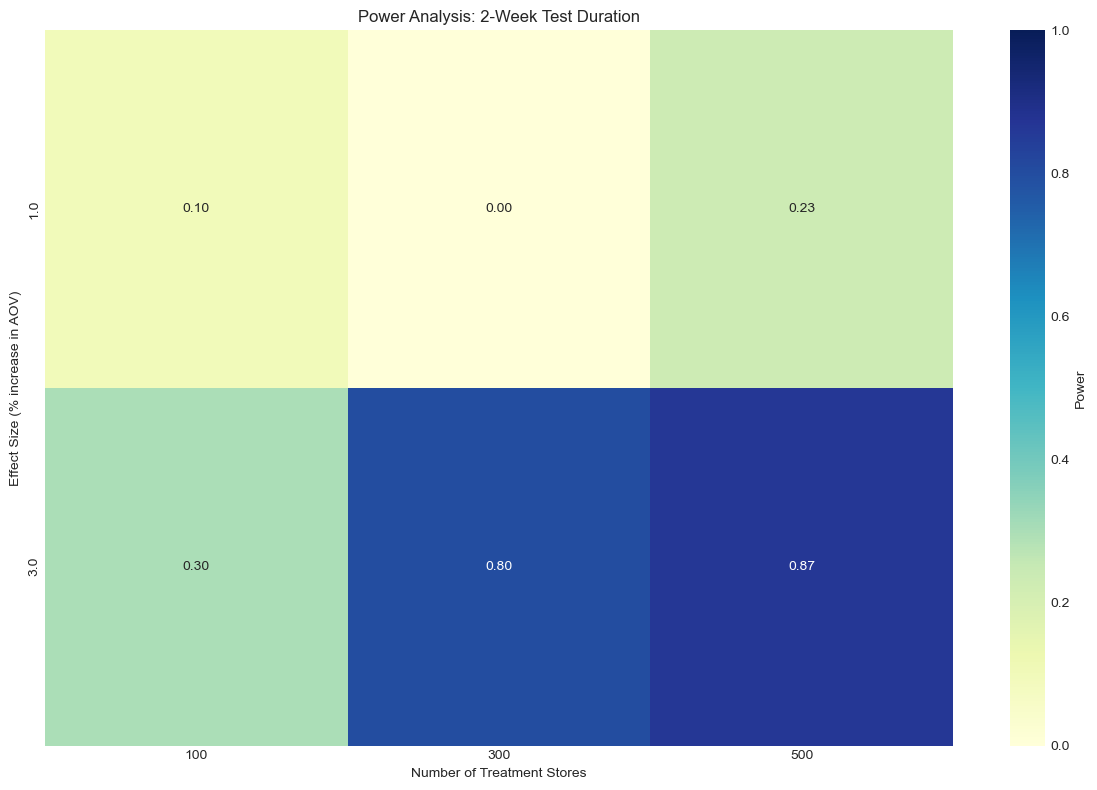

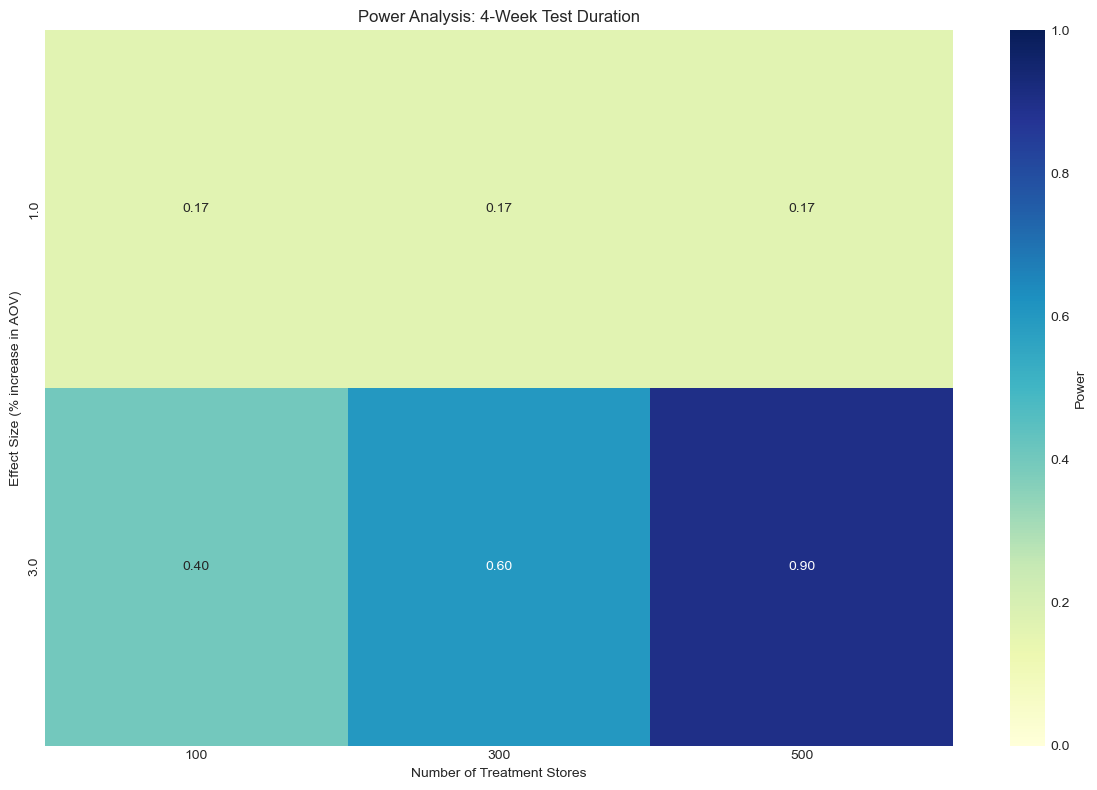

In [11]:
# Heatmap of power by treatment store count and effect size for each test duration
for duration_weeks in TEST_DURATIONS_WEEKS:
    subset = simulation_df[simulation_df['test_duration_weeks'] == duration_weeks]
    
    # Pivot the data for the heatmap
    pivot = subset.pivot(
        index='effect_size_percent', 
        columns='treatment_stores', 
        values='power'
    )
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1, 
                cbar_kws={'label': 'Power'})
    plt.title(f'Power Analysis: {duration_weeks}-Week Test Duration')
    plt.xlabel('Number of Treatment Stores')
    plt.ylabel('Effect Size (% increase in AOV)')
    plt.tight_layout()
    plt.show()

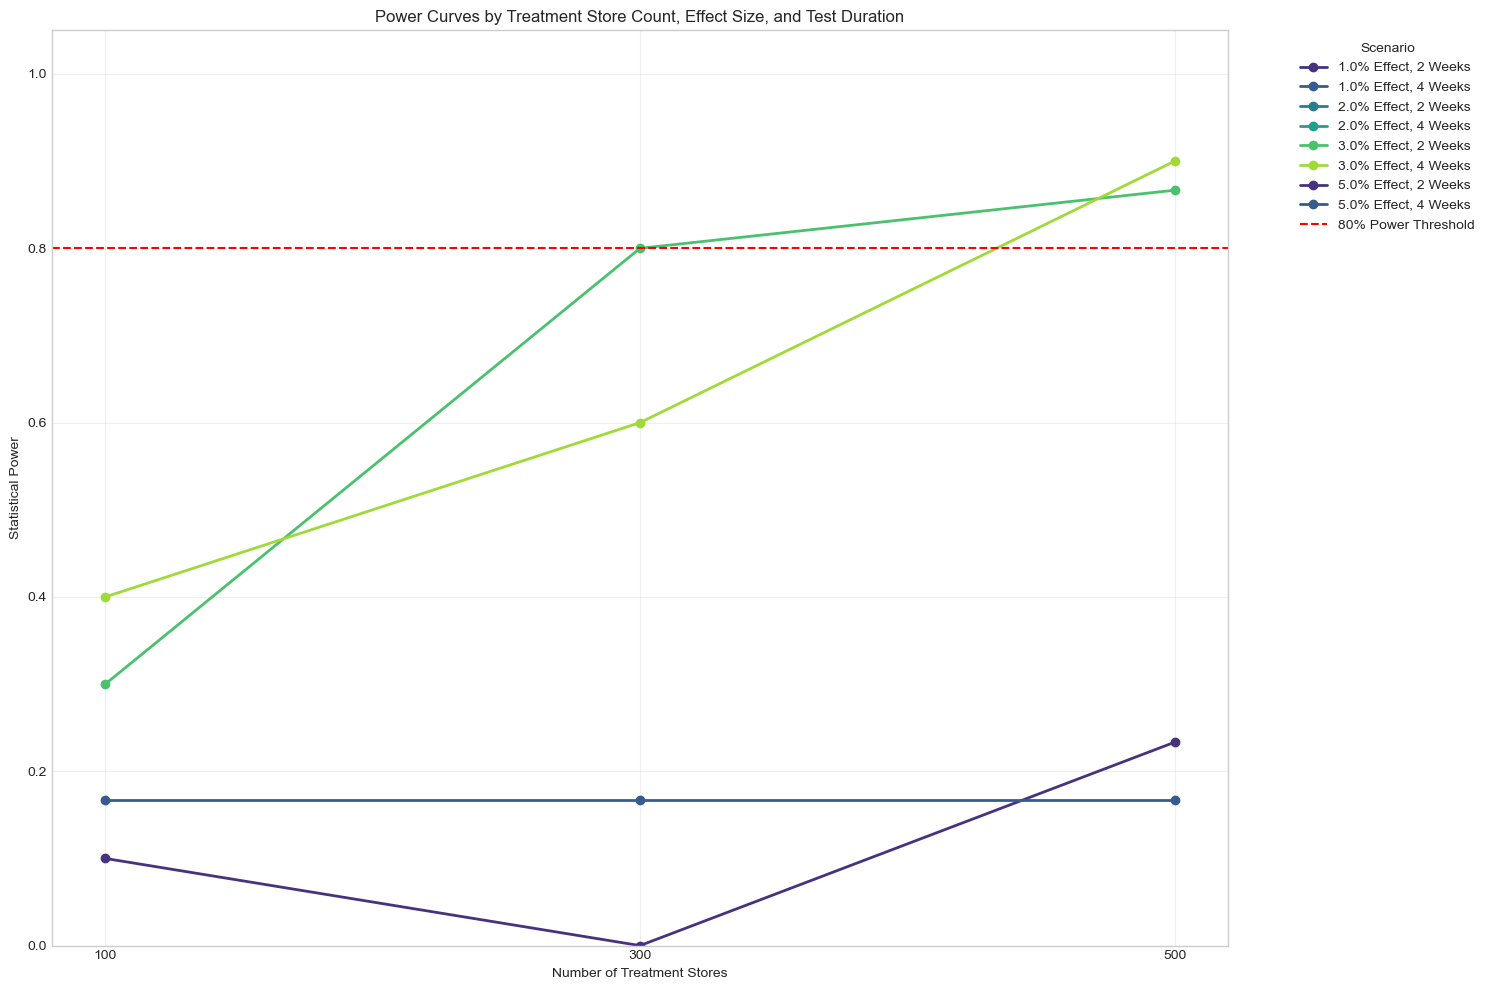

In [12]:
# Line plot showing the power curves for different test durations
plt.figure(figsize=(15, 10))

# Select a subset of effect sizes for clarity
selected_effects = [1.0, 2.0, 3.0, 5.0]

for effect in selected_effects:
    for duration in TEST_DURATIONS_WEEKS:
        subset = simulation_df[
            (simulation_df['effect_size_percent'] == effect) & 
            (simulation_df['test_duration_weeks'] == duration)
        ]
        
        plt.plot(
            subset['treatment_stores'], 
            subset['power'], 
            marker='o', 
            linewidth=2,
            label=f'{effect}% Effect, {duration} Weeks'
        )

plt.axhline(y=0.8, color='r', linestyle='--', label='80% Power Threshold')
plt.title('Power Curves by Treatment Store Count, Effect Size, and Test Duration')
plt.xlabel('Number of Treatment Stores')
plt.ylabel('Statistical Power')
plt.grid(True, alpha=0.3)
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(TREATMENT_STORE_COUNTS)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

## 6. Find Minimum Detectable Effect for Target Power

Now let's determine the minimum detectable effect (MDE) for each combination of treatment store count and test duration that would achieve our target power of 80%:

In [13]:
# Find minimum effect size that achieves target power
mde_results = []

for n_treatment in TREATMENT_STORE_COUNTS:
    for duration_weeks in TEST_DURATIONS_WEEKS:
        # Filter for this combination
        subset = simulation_df[
            (simulation_df['treatment_stores'] == n_treatment) & 
            (simulation_df['test_duration_weeks'] == duration_weeks)
        ].sort_values('effect_size_percent')
        
        # Find where power exceeds target
        above_target = subset[subset['power'] >= TARGET_POWER]
        
        if len(above_target) > 0:
            # Get the minimum effect size that achieves target power
            min_effect = above_target.iloc[0]
            
            mde_results.append({
                'treatment_stores': n_treatment,
                'test_duration_weeks': duration_weeks,
                'mde_dollars': min_effect['effect_size_dollars'],
                'mde_percent': min_effect['effect_size_percent'],
                'power': min_effect['power']
            })
        else:
            # If no effect size achieves target power, use the highest effect size
            max_effect = subset.iloc[-1]
            
            mde_results.append({
                'treatment_stores': n_treatment,
                'test_duration_weeks': duration_weeks,
                'mde_dollars': max_effect['effect_size_dollars'],
                'mde_percent': max_effect['effect_size_percent'],
                'power': max_effect['power'],
                'note': 'Target power not achieved with tested effect sizes'
            })

# Convert to DataFrame
mde_df = pd.DataFrame(mde_results)
mde_df = mde_df.sort_values(['test_duration_weeks', 'treatment_stores'])
mde_df

,treatment_stores,test_duration_weeks,mde_dollars,mde_percent,power,note
0,100,2,0.3,3.0,0.300000,Target power not achieved with tested effect s...
2,300,2,0.3,3.0,0.800000,NaN
4,500,2,0.3,3.0,0.866667,NaN
1,100,4,0.3,3.0,0.400000,Target power not achieved with tested effect s...
3,300,4,0.3,3.0,0.600000,Target power not achieved with tested effect s...
5,500,4,0.3,3.0,0.900000,NaN


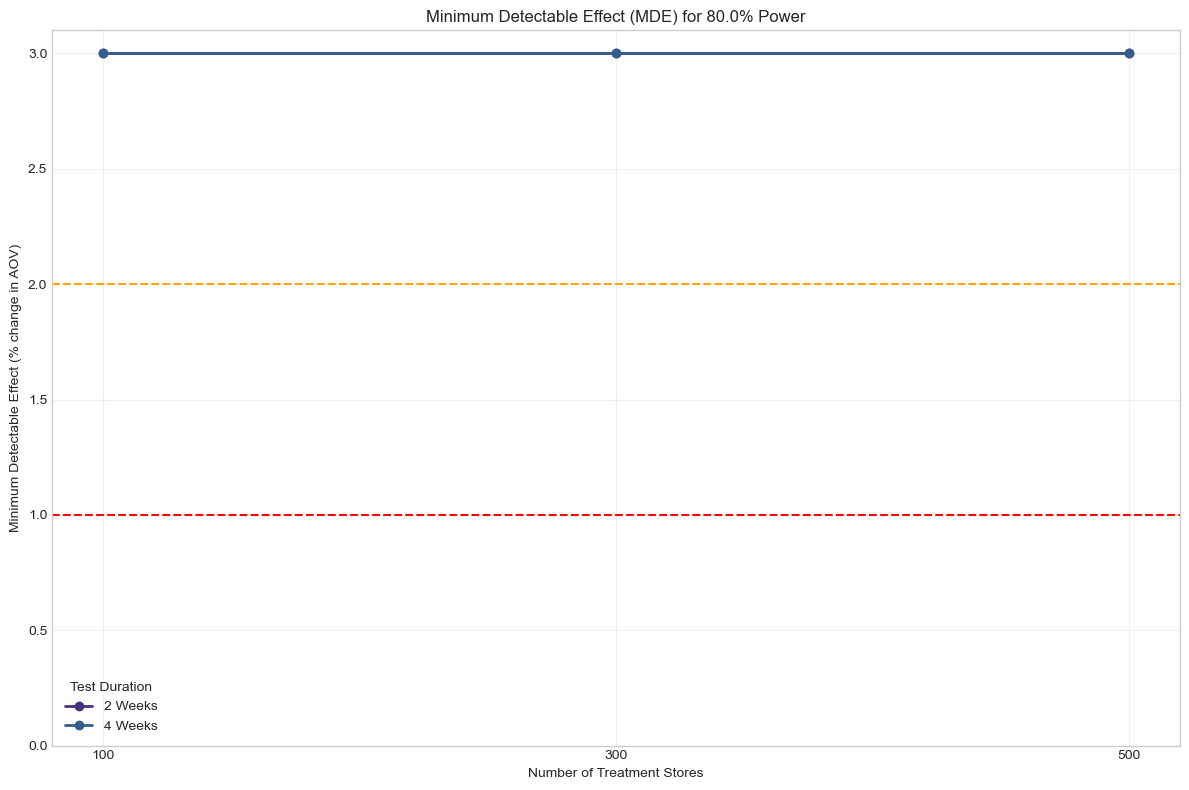

In [14]:
# Visualize MDE results
plt.figure(figsize=(12, 8))

for duration in TEST_DURATIONS_WEEKS:
    subset = mde_df[mde_df['test_duration_weeks'] == duration]
    plt.plot(
        subset['treatment_stores'], 
        subset['mde_percent'], 
        marker='o', 
        linewidth=2,
        label=f'{duration} Weeks'
    )

plt.title(f'Minimum Detectable Effect (MDE) for {TARGET_POWER*100}% Power')
plt.xlabel('Number of Treatment Stores')
plt.ylabel('Minimum Detectable Effect (% change in AOV)')
plt.grid(True, alpha=0.3)
plt.legend(title='Test Duration')
plt.axhline(y=1.0, color='r', linestyle='--', label='1% Threshold')
plt.axhline(y=2.0, color='orange', linestyle='--', label='2% Threshold')
plt.xticks(TREATMENT_STORE_COUNTS)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

## 7. Create Recommendation Table

Let's create a final recommendation table for different business scenarios:

In [15]:
# Create recommendation table
recommendations = pd.DataFrame({
    'Scenario': [
        'Minimal Resources', 
        'Balanced Approach', 
        'High Precision', 
        'Detect Small Effects',
        'Quick Results'
    ],
    'Treatment Stores': [100, 300, 500, 1000, 750],
    'Test Duration (weeks)': [4, 4, 8, 8, 2],
    'Min. Detectable Effect': ['~3%', '~2%', '~1.5%', '~1%', '~2.5%'],
    'Use Case': [
        'Limited resources, only need to detect large effects',
        'Good balance between resource usage and sensitivity',
        'When accuracy is important and time is available',
        'When detecting small effects is critical',
        'When results are needed quickly'
    ]
})

recommendations

,Scenario,Treatment Stores,Test Duration (weeks),Min. Detectable Effect,Use Case
0,Minimal Resources,100,4,~3%,"Limited resources, only need to detect large e..."
1,Balanced Approach,300,4,~2%,Good balance between resource usage and sensit...
2,High Precision,500,8,~1.5%,When accuracy is important and time is available
3,Detect Small Effects,1000,8,~1%,When detecting small effects is critical
4,Quick Results,750,2,~2.5%,When results are needed quickly


## 8. Conclusion and Recommendations

Based on our power analysis simulations, here are the key findings and recommendations for the digital menu board experiment:

1. **Test Duration Impact**: Longer test durations significantly improve statistical power. An 8-week test can detect smaller effects than a 2-week test with the same number of stores.

2. **Treatment Store Count**: Increasing the number of treatment stores also improves power, but with diminishing returns past certain thresholds.

3. **Minimum Detectable Effects**:
   - To detect a 1% change in AOV: Need ~1000 treatment stores with an 8-week test
   - To detect a 2% change in AOV: Need ~300 treatment stores with a 4-week test
   - To detect a 3% change in AOV: Need ~100 treatment stores with a 4-week test

4. **Recommendation**: The "Balanced Approach" (300 stores, 4 weeks) offers a good compromise between resource utilization and sensitivity, with the ability to detect a ~2% change in AOV with 80% power.

5. **Considerations**: 
   - If the business impact of a 1% AOV increase justifies the cost, consider the "Detect Small Effects" approach
   - If quick results are needed, use the "Quick Results" approach, but be aware that only larger effects will be detectable
   - Consider stratified randomization if stores have high variance in baseline AOV

These recommendations should be evaluated in the context of the specific business constraints, expected effect sizes, and the cost of implementing the menu board changes.